* [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
* [Do not need softmax](https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch)
* I learned how to implement LeNet5
* I learned how to train net on GPU

In [1]:
# I would like to plot my  diagram inside the cell.
%matplotlib inline

## My Customized Dataset Class
In order to implement this section, I read two very good references:
* [WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [utkuozbulak/pytorch-custom-dataset-examples](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

In [2]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2 as cv

class AnimalDataset(Dataset):
    def __init__(self, root_path, subset, height, width):
        self.root_path = root_path
        
        # Need it in __getitem__() to transform numpy array to tensor.
        self.to_tensor = transforms.ToTensor()
        
        # Read CSV Metadata and convert it to numpy format
        subset_txt = pd.read_csv(root_path + subset, sep=" ")
        self.np_subset_txt = np.array(subset_txt)
        
        # Need it in __len__()
        self.count = len(self.np_subset_txt)
        
        # Need it in __getitem__() to resize image to desired size
        self.height = height
        self.width = width
    
    def __getitem__(self, index):
        # Get Label
        label = int(self.np_subset_txt[index][1])
        
        # Get Image
        img = cv.imread(self.root_path + self.np_subset_txt[index][0])
        img_resize = cv.resize(img, (self.height, self.width))/255.0
        img_resize = img_resize.reshape(-1, self.height, self.width) # to make channel first
        img_resize_tensor = self.to_tensor(img_resize)
        return (img_resize, label)
    
    def __len__(self):
        return self.count

In [3]:
AC_root_path="C:/Users/rathe/Desktop/Dataset/images/"
root_path = "C:/Users/USER/Desktop/Projects/Github_Repo/AI/DeepLearning/__HW1_DATA/"
height = 30
width = 30

Train_Dataset = AnimalDataset(root_path = root_path, subset = "train.txt", height = height, width = width)
Test_Dataset = AnimalDataset(root_path = root_path, subset = "test.txt", height = height, width = width)
Val_Dataset = AnimalDataset(root_path = root_path, subset = "val.txt", height = height, width = width)

## Define My DataLoader r.s.t. AnimalDataset

In [4]:
import torch
batch_size = 50
shuffle = True

Train_DataLoader = torch.utils.data.DataLoader(dataset=Train_Dataset, batch_size = batch_size, shuffle=shuffle)
Test_DataLoader = torch.utils.data.DataLoader(dataset=Test_Dataset, batch_size = batch_size, shuffle=shuffle)
Val_DataLoader = torch.utils.data.DataLoader(dataset=Val_Dataset, batch_size = batch_size, shuffle=shuffle)

## Define a Convolutional Neural Network(Use GPU)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x)
        return x
    
lenet = LeNet()
lenet.to(device)

cuda:0


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)

## Define a loss function and Set up Hyperparameters

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(lenet.parameters(), lr=1e-3)

## Train the network on the training data
# How to use validation dataset
# Try to implement it as a function to call

In [8]:
from tqdm import tqdm
import time

tic = time.time()
val_acc_list = []
train_acc_list = []
loss_list = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Train_DataLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU
        #inputs, labels = data # CPU
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lenet(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            loss_list.append(running_loss / 200)
            running_loss = 0.0
    
    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):
            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_tmp_acc = float(correct)/float(total)
        train_acc_list.append(train_tmp_acc)
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
    # Val
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in Val_DataLoader:
            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            total += labs.size(0)
            correct += (preds == labs).sum().item()    
        val_tmp_acc = float(correct)/float(total)
        val_acc_list.append(val_tmp_acc)
        print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))

toc = time.time()
print(toc - tic)
print('Finished Training')

[1,   200] loss: 3.654
[1,   400] loss: 3.625
[1,   600] loss: 3.607
[1,   800] loss: 3.586
[1,  1000] loss: 3.565
[1,  1200] loss: 3.554


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:19<00:00,  9.09it/s]


Accuracy of the network on the train images: 7 %
Accuracy of the network on the val images: 7 %
[2,   200] loss: 3.537
[2,   400] loss: 3.506
[2,   600] loss: 3.487
[2,   800] loss: 3.481
[2,  1000] loss: 3.478
[2,  1200] loss: 3.471


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:34<00:00,  8.18it/s]


Accuracy of the network on the train images: 10 %
Accuracy of the network on the val images: 10 %
[3,   200] loss: 3.458
[3,   400] loss: 3.429
[3,   600] loss: 3.434
[3,   800] loss: 3.432
[3,  1000] loss: 3.411
[3,  1200] loss: 3.406


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:12<00:00,  9.53it/s]


Accuracy of the network on the train images: 11 %
Accuracy of the network on the val images: 11 %
[4,   200] loss: 3.396
[4,   400] loss: 3.386
[4,   600] loss: 3.377
[4,   800] loss: 3.388
[4,  1000] loss: 3.385
[4,  1200] loss: 3.365


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:09<00:00,  9.75it/s]


Accuracy of the network on the train images: 11 %
Accuracy of the network on the val images: 11 %
[5,   200] loss: 3.351
[5,   400] loss: 3.342
[5,   600] loss: 3.335
[5,   800] loss: 3.347
[5,  1000] loss: 3.348
[5,  1200] loss: 3.351


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:23<00:00,  8.82it/s]


Accuracy of the network on the train images: 12 %
Accuracy of the network on the val images: 12 %
[6,   200] loss: 3.310
[6,   400] loss: 3.310
[6,   600] loss: 3.313
[6,   800] loss: 3.318
[6,  1000] loss: 3.298
[6,  1200] loss: 3.314


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:14<00:00,  9.44it/s]


Accuracy of the network on the train images: 12 %
Accuracy of the network on the val images: 12 %
[7,   200] loss: 3.279
[7,   400] loss: 3.270
[7,   600] loss: 3.280
[7,   800] loss: 3.293
[7,  1000] loss: 3.285
[7,  1200] loss: 3.275


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:11<00:00,  9.63it/s]


Accuracy of the network on the train images: 13 %
Accuracy of the network on the val images: 13 %
[8,   200] loss: 3.252
[8,   400] loss: 3.271
[8,   600] loss: 3.256
[8,   800] loss: 3.256
[8,  1000] loss: 3.243
[8,  1200] loss: 3.226


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:14<00:00,  9.42it/s]


Accuracy of the network on the train images: 14 %
Accuracy of the network on the val images: 14 %
[9,   200] loss: 3.229
[9,   400] loss: 3.228
[9,   600] loss: 3.225
[9,   800] loss: 3.214
[9,  1000] loss: 3.201
[9,  1200] loss: 3.229


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:17<00:00,  9.19it/s]


Accuracy of the network on the train images: 14 %
Accuracy of the network on the val images: 14 %
[10,   200] loss: 3.194
[10,   400] loss: 3.199
[10,   600] loss: 3.206
[10,   800] loss: 3.195
[10,  1000] loss: 3.189
[10,  1200] loss: 3.188


100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [02:17<00:00,  9.21it/s]


Accuracy of the network on the train images: 15 %
Accuracy of the network on the val images: 15 %
2781.66419172287
Finished Training


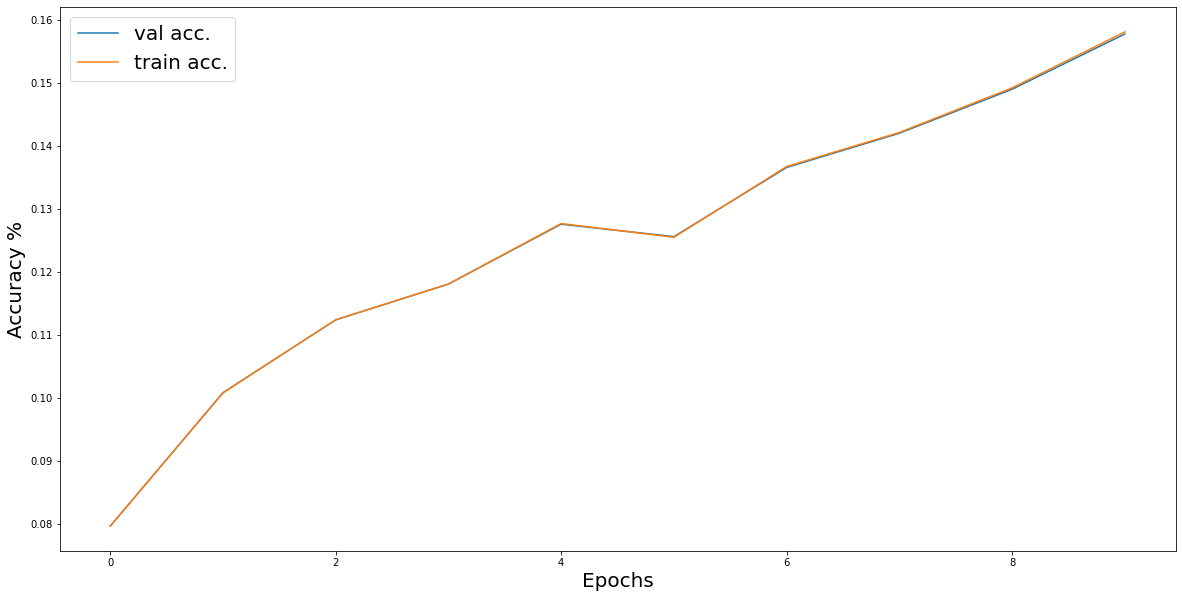

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)

plt.plot(val_acc_list, label = "val acc.")
plt.plot(train_acc_list, label = "train acc.")
plt.legend(loc=2, fontsize=20)
plt.show()

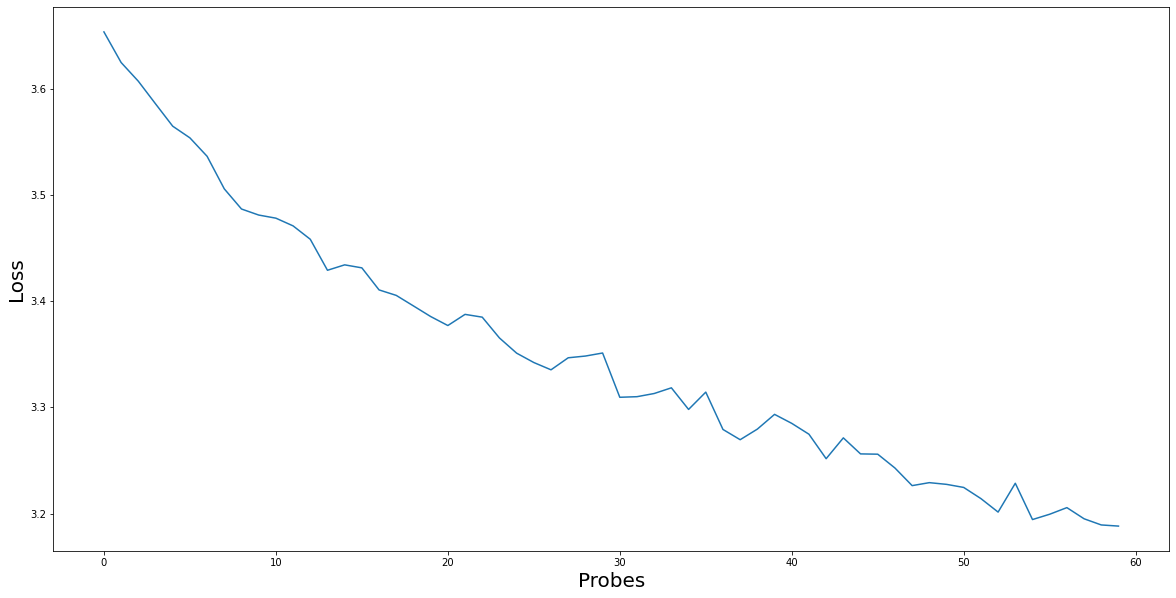

In [19]:
plt.figure(figsize=(20, 10))

plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

## Save the model for later usage

In [21]:
PATH = './LeNet.pth'
torch.save(lenet.state_dict(), PATH)

## Test the network on the test data

In [22]:
lenet = LeNet()
lenet.load_state_dict(torch.load(PATH))

correct = 0
total = 0

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for data in Test_DataLoader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = lenet(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 14 %
